# Question 5

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

For Question 5 i have again created another notebook and started with importing all the necessary libraries and also importing train_test_split for splitting the data.

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [4]:
train_data, development_data = train_test_split(raw_training_data, train_size=0.8, shuffle=False)

Here i have splitted the data with train_test_split into training data which is 80% and 20% which is development data.

In [5]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    

    preprocessed_example = [] # trivial- no preprocessing
    postagger = CRFTagger()
    postagger .set_model_file("crf_pos.tagger")
    Words=[]
    for i in example:
        Words.append(i[0])
        postagwords= postagger.tag(Words)
        for j in range (len(postagwords)):
            str = ''
            str = str + postagwords[j][0] + '@' + postagwords[j][1]
            word = tuple([str, example[j][1]])
            preprocessed_example.append(word)
    return preprocessed_example

Here again in the preProcess function I have concated the word and their respective pos tags with '@' tags because the CRF tagger takes string as input so we have to concat the words and pos tags.

In [6]:
development_data1 = [preProcess(example) for example in development_data]

In [7]:
train_data1 = [preProcess(example) for example in train_data]

Here we have preprocessed both the training data and development_data and printed the first value of the development_data.

In [8]:
print(development_data1[0])

[('what@WP', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@NN', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@NN', 'O'), ('rated@VBN', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@NN', 'O'), ('rated@VBD', 'O'), ('thriller@JJR', 'B-GENRE'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@GW', 'O'), ('rated@^JJ', 'O'), ('thriller@NN', 'B-GENRE'), ('directed@VBN', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@GW', 'O'), ('rated@^JJ', 'O'), ('thriller@NN', 'B-GENRE'), ('directed@VBN', 'O'), ('by@IN', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@GW', 'O'), ('rated@^JJ', 'O'), ('thriller@NN', 'B-GENRE'), ('directed@VBN', 'O'), ('by@IN', 'O'), ('dover@RB', 'B-DIRECTOR'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@GW', 'O'), ('rated@^JJ', 'O'), ('thriller@NN', 'B-GENRE'), ('directed@VBN', 'O'), ('by@IN', 'O'), ('dover@NN

In [9]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []
    word_token = token.split('@')
    actual_word = word_token[0]
    pos_tag = word_token[1]
    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
        
    if idx-1 >= 0:
        previous_token = tokens[idx-1] 
        new_tokens = previous_token.split('@')
        prev_word = new_tokens[0]
        prev_tag = new_tokens[1]
        # Annotating the previous actual word
        feature_list.append("PREV_WORD_" + prev_word)
        # Annotating the previous actual word's POS Tag
        feature_list.append("PREV_POS_" + prev_tag) 
     # Getting next word and its corresponding POS tag
    if idx+1 < len(tokens):
        next_token = tokens[idx+1] 
        new_tokens = next_token.split('@')
        next_word = new_tokens[0]
        next_tag = new_tokens[1]
        # Annotating the next actual word
        feature_list.append("NEXT_WORD_" + next_word)
        # Annotating the next actual word's POS Tag
        feature_list.append("NEXT_POS_" + next_tag)
    # Prefix up to length 3
    if len(actual_word) > 2:
        feature_list.append("PRE_" + actual_word[:2])
    if len(actual_word) > 3:
        feature_list.append("PRE_" + actual_word[:3])    
    feature_list.append("LOW_WORD_" + actual_word.lower())
    if '-' in actual_word:
        feature_list.append("HAS_HYPHEN")
        
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + pos_tag)
    #print(feature_list)
    return feature_list


In this get_feature function i have used prefixes, suffixes, previous pos tags, next pos tags, checked the string if its capital or a number or a punctutation mark.

So, this is my final Permutation Combination before this i tried various options and there results are as follows:

First I tried by adding only next words and its corresponding pos tags and the hyphen function
the Macro avg precision recall and support were 0.68, 0.63, 0.64 respectively for development data.

Next i tried by using the previous words and pos tags and remvoing the next words and pos tags and keeping the hyphen function the macro avg precision recall and f1-score were 0.73, 0.67,0.68 respectively for development data.

Then i tried with previous and next words and their pos tags and removed the Hyphen funciton and the macro avg precision recall and f1-score i got were 0.74, 0.66, 0.68 respectively for development data.


Then i tried without the prefix words and the precision recall and f score i got was 0.74, 0.64,0.67 respectively for development data

Then after all these options i got the above combination which gave me the highest macro avg for precision recall and f1 score for development data which is 0.74, 0.66, 0.68 respectively for development data.





In [10]:
TAGGER_PATH = "crf_nlu_train_pos_improved.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
print("training tagger...")
ct.train(train_data1, TAGGER_PATH)
print("done")

training tagger...
done


Here we have trained the tagger on the preprocessed training data which is train_data1.

In [11]:
print("testing tagger...")
preds2 = []
y_test2 = []
for sent in development_data1:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds2.extend(sent_preds)
    y_test2.extend(sent_true)
print("done")

testing tagger...
done


Now after training the data we have tested the data on the preprocessed development data which is development_data1.

In [12]:
print(classification_report(y_test2, preds2))

c:\users\rohit\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.85      0.93      0.89      2496
      B-CHARACTER       0.79      0.31      0.45       205
       B-DIRECTOR       0.95      0.84      0.89      1854
          B-GENRE       0.98      0.98      0.98      7157
           B-PLOT       0.85      0.82      0.84      1761
         B-RATING       0.99      1.00      0.99      3644
B-RATINGS_AVERAGE       0.92      0.95      0.93      3193
         B-REVIEW       0.00      0.00      0.00       208
           B-SONG       0.62      0.32      0.42       120
          B-TITLE       0.81      0.54      0.65      2226
        B-TRAILER       0.96      0.17      0.28       163
           B-YEAR       0.87      0.99      0.93      3120
          I-ACTOR       0.85      0.87      0.86      2428
      I-CHARACTER       0.56      0.27      0.36       173
       I-DIRECTOR       0.93      0.81      0.87      1704
          I-GENRE       0.91      1.00      0.96       

So for the development_data we get macro avg precision as 0.74 , recall as 0.66 and f1 score as 0.68.
So comparing this classification report with the classification report from the question 4 we can see a significance increase in macro averages of Precision and recall.

                                precision         recall       f1-score
                (Current Q5.)    0.74              0.66          0.68
   
                (Previous Q4.)   0.68              0.62          0.63


So we can clearly see that by increasing the features and optimizing it to the best combination there is an increase in the efficiency of the classifier.

In [13]:
def confusion_matrix_heatmap(y_test2, preds2):
    labels = list(set(y_test2))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test2, preds2, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)
    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

c:\users\rohit\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['B-TRAILER', 'O', 'I-RATINGS_AVERAGE', 'B-YEAR', 'I-REVIEW', 'I-SONG', 'I-PLOT', 'I-DIRECTOR', 'B-PLOT', 'I-CHARACTER', 'B-CHARACTER', 'I-TRAILER', 'B-DIRECTOR', 'I-RATING', 'B-SONG', 'B-RATING', 'I-YEAR', 'I-ACTOR', 'B-RATINGS_AVERAGE', 'B-REVIEW', 'B-ACTOR', 'I-TITLE', 'B-TITLE', 'I-GENRE', 'B-GENRE'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


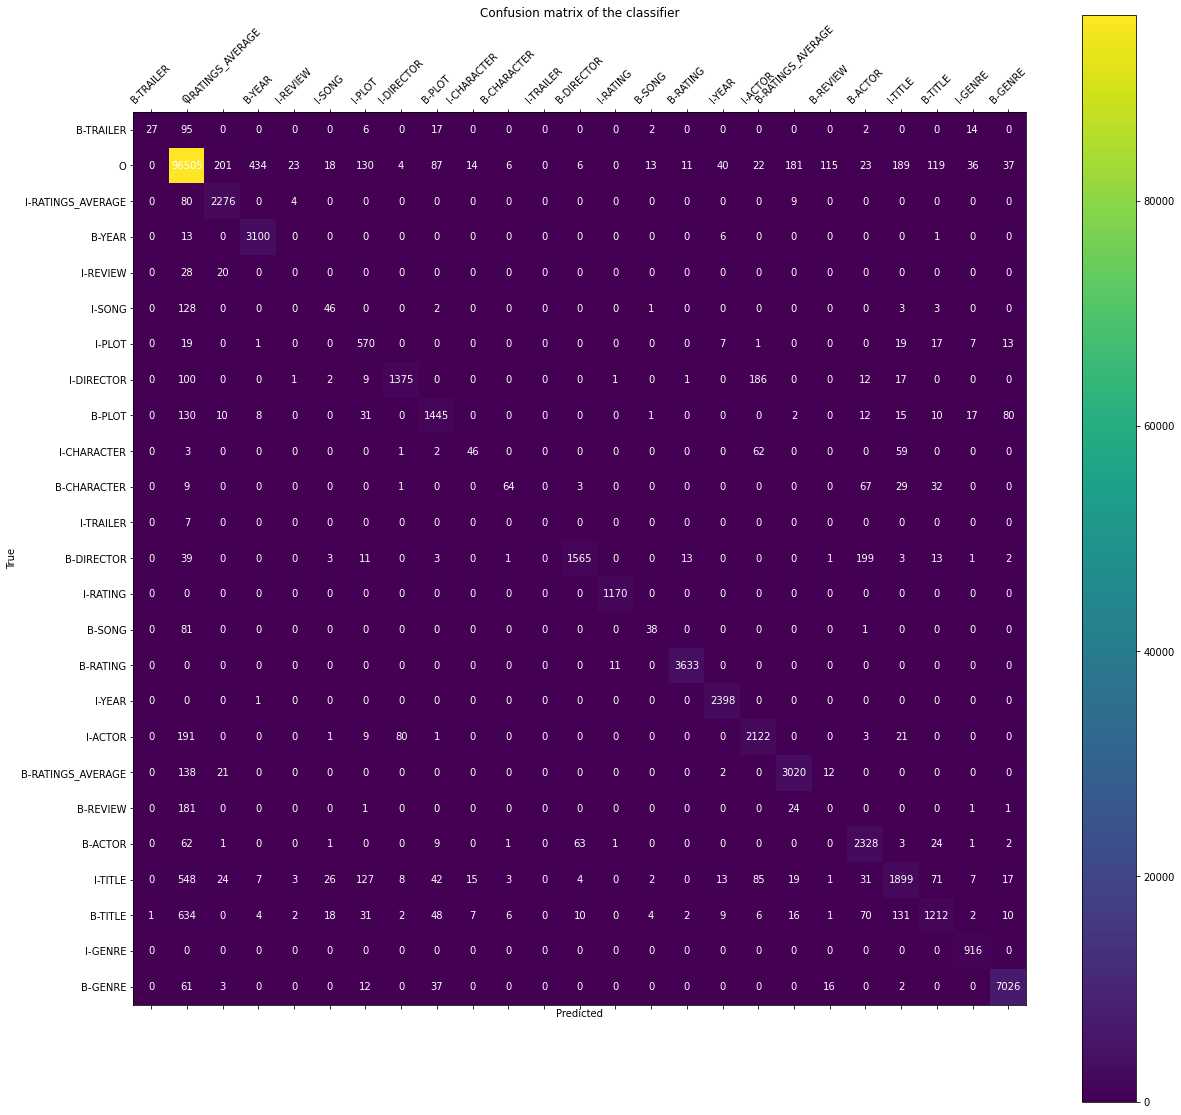

In [14]:
confusion_matrix_heatmap(y_test2, preds2)

In [15]:
TAGGER_PATH = "crf_nlu_train_improved.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
print("training tagger...")
ct.train(train_data1, TAGGER_PATH)
print("done")

training tagger...
done


In [16]:
ct = CRFTagger(feature_func=get_features)
ct.set_model_file(TAGGER_PATH)
data_test = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in data_test]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
158305 words


Now again after training the data in the train_data1 which is preprocessed trainin gdata and then testing it on the preprocessed data which is engtest.bio.txt 

In [17]:
print("testing tagger...")
preds3 = []
y_test3 = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds3.extend(sent_preds)
    y_test3.extend(sent_true)
print("done")

testing tagger...
done


After testing the data on the test data I printed the classification report below.

In [18]:
print(classification_report(y_test3, preds3))

                   precision    recall  f1-score   support

          B-ACTOR       0.86      0.91      0.88      4409
      B-CHARACTER       0.71      0.46      0.56       353
       B-DIRECTOR       0.88      0.79      0.83      2691
          B-GENRE       0.94      0.96      0.95      7653
           B-PLOT       0.73      0.58      0.65      2455
         B-RATING       0.99      0.99      0.99      4080
B-RATINGS_AVERAGE       0.90      0.85      0.88      2667
         B-REVIEW       0.34      0.16      0.22       274
           B-SONG       0.74      0.47      0.58       268
          B-TITLE       0.73      0.60      0.66      1858
        B-TRAILER       0.78      0.53      0.63       144
           B-YEAR       0.92      0.95      0.94      3822
          I-ACTOR       0.85      0.91      0.88      3837
      I-CHARACTER       0.48      0.26      0.34       234
       I-DIRECTOR       0.88      0.80      0.84      2425
          I-GENRE       0.87      0.77      0.82      1

Here we get the macro average precision as 0.75, recall as 0.66 and f1 score as 0.69. 

From the above classification report and comparing it to the first classification report The precision, recall and f1-score of B-REVIEW and I-REVIEW was zero in the first report and now in the above report after adding pos tags and finding the right combination there us significant increase in their values which are as follows:

                    Precision      Recall     f1- score
         B-REVIEW       0.34         0.16        0.22
         I-REVIEW       0.33         0.08        0.13
Moreover there can be seen a significance improvement in precision, recall and f1-score in most of the classes in this classification report comparing to the previous classification report.

In [19]:
def confusion_matrix_heatmap(y_test3, preds3):
    labels = list(set(y_test3))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test3, preds3, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)
    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

c:\users\rohit\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['B-TRAILER', 'O', 'B-YEAR', 'I-RATINGS_AVERAGE', 'I-REVIEW', 'I-SONG', 'I-PLOT', 'I-DIRECTOR', 'B-PLOT', 'I-CHARACTER', 'B-CHARACTER', 'I-TRAILER', 'B-DIRECTOR', 'I-RATING', 'B-SONG', 'B-RATING', 'I-YEAR', 'I-ACTOR', 'B-RATINGS_AVERAGE', 'B-REVIEW', 'B-ACTOR', 'I-TITLE', 'B-TITLE', 'I-GENRE', 'B-GENRE'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


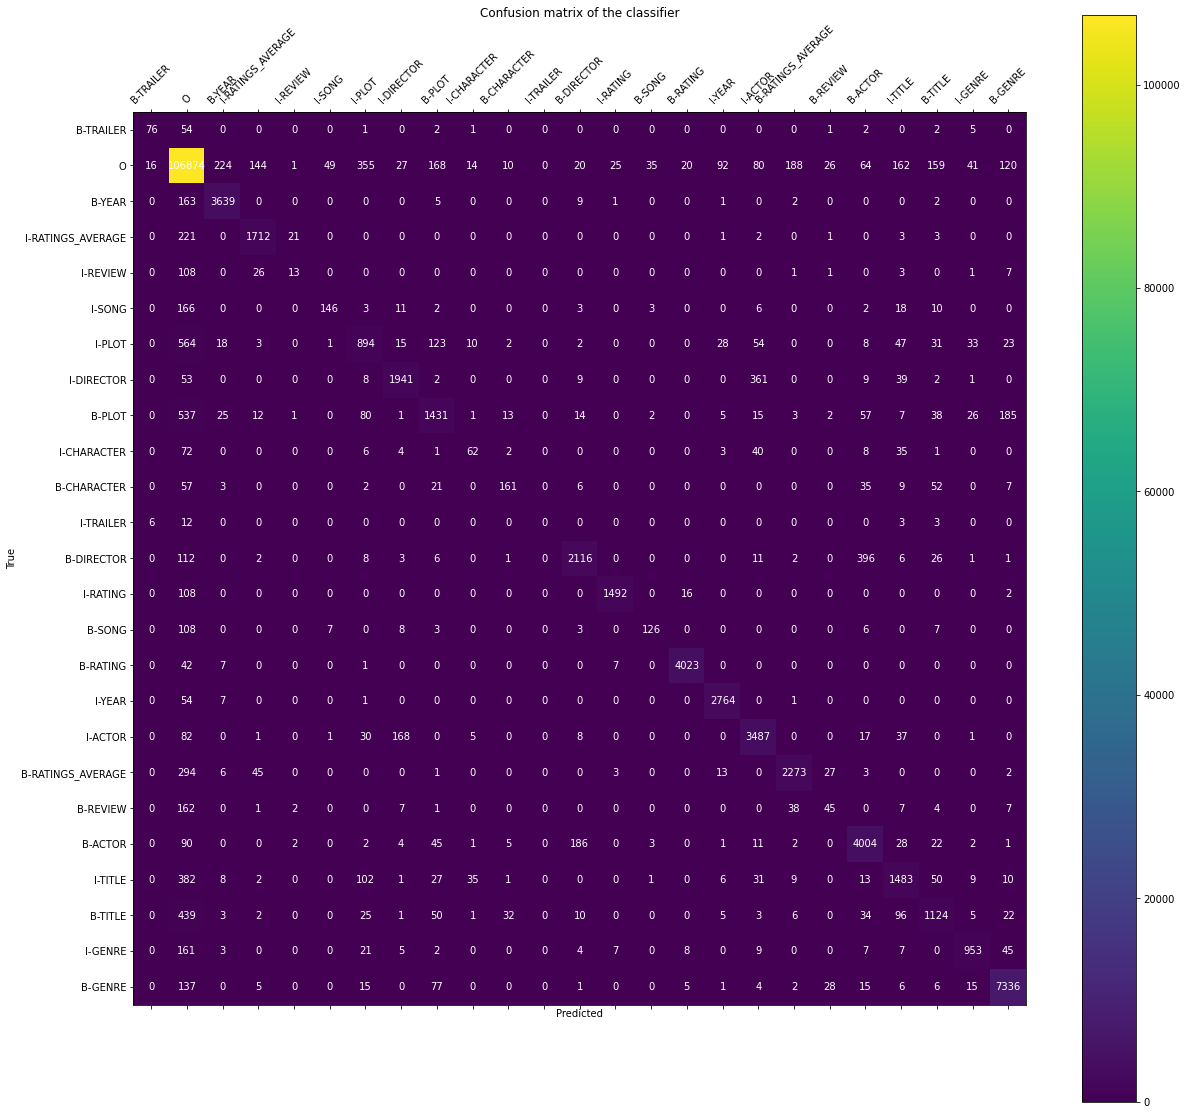

In [20]:
confusion_matrix_heatmap(y_test3, preds3)

This is the confusion matrix for test data.